# DiGraph Overview

https://networkx.org/documentation/stable/reference/algorithms/bipartite.html?highlight=bipartite#module-networkx.algorithms.bipartite

In [264]:
import networkx as nx
import psycopg2
import pandas as pd 
import sqlalchemy as salc
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import datetime
import json
from networkx.algorithms import bipartite
#from networkx.algorithms import digraph
warnings.filterwarnings('ignore')



In [265]:
with open("config.json") as config_file:
    config = json.load(config_file)

database_connection_string = 'postgresql+psycopg2://{}:{}@{}:{}/{}'.format(config['user'], config['password'], config['host'], config['port'], config['database'])

dbschema='augur_data'
engine = salc.create_engine(
    database_connection_string,
    connect_args={'options': '-csearch_path={}'.format(dbschema)})

In [227]:
DG = nx.DiGraph()

In [228]:
DG.add_weighted_edges_from([(1, 2, 0.5), (3, 1, 0.75)])

DG.out_degree(1, weight='weight')

0.5

In [229]:
list(DG.successors(1))



[2]

In [230]:
list(DG.neighbors(1))

[2]

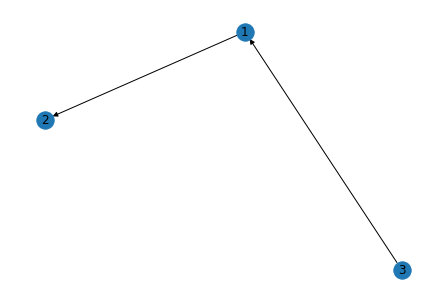

In [231]:
nx.draw(DG, with_labels=True)

# Getting Actual Augur Network Data

In [243]:
contrib_net = pd.DataFrame()

net_query = salc.sql.text(f"""
            SELECT 
                a.cntrb_id,
                a.repo_id,
                b.repo_name,
                b.repo_git,
                a.login, 
                MAX ( RANK ) AS weight 
            FROM
                explorer_contributor_actions a,
                repo b 
            WHERE
                a.repo_id = b.repo_id and a.repo_id = 1
            GROUP BY
                a.cntrb_id,
                a.repo_id,
                b.repo_name,
                b.repo_git,
                a."login"
            ORDER BY
                repo_id;  

                """)

network = pd.read_sql(net_query, con=engine)

display(network)

network.dtypes

,cntrb_id,repo_id,repo_name,repo_git,login,weight
0,52745,1,rails,https://github.com/rails/rails.git,elliterate,2
1,56363,1,rails,https://github.com/rails/rails.git,gogainda,1
2,56592,1,rails,https://github.com/rails/rails.git,clausd,1
3,26375,1,rails,https://github.com/rails/rails.git,edwinlunando,2
4,37224,1,rails,https://github.com/rails/rails.git,fredwu,18
...,...,...,...,...,...,...
4958,57142,1,rails,https://github.com/rails/rails.git,daigong,1
4959,56783,1,rails,https://github.com/rails/rails.git,ogonbat,1
4960,31414,1,rails,https://github.com/rails/rails.git,r00takaspin,1
4961,33234,1,rails,https://github.com/rails/rails.git,zhuochun,1


cntrb_id      int64
repo_id       int64
repo_name    object
repo_git     object
login        object
weight        int64
dtype: object

In [244]:
augDG = nx.Graph()

In [245]:
weighted_edges = (network['cntrb_id'], network['repo_git'], network['weight'])

In [246]:
networker = pd.DataFrame(weighted_edges)
networker = networker.transpose()

In [247]:
augDG.add_nodes_from(networker['cntrb_id'], bipartite=0)

In [248]:
augDG.add_nodes_from(networker['repo_git'], bipartite=1)

In [249]:
print(networker)

     cntrb_id                            repo_git weight
0       52745  https://github.com/rails/rails.git      2
1       56363  https://github.com/rails/rails.git      1
2       56592  https://github.com/rails/rails.git      1
3       26375  https://github.com/rails/rails.git      2
4       37224  https://github.com/rails/rails.git     18
...       ...                                 ...    ...
4958    57142  https://github.com/rails/rails.git      1
4959    56783  https://github.com/rails/rails.git      1
4960    31414  https://github.com/rails/rails.git      1
4961    33234  https://github.com/rails/rails.git      1
4962    34157  https://github.com/rails/rails.git      1

[4963 rows x 3 columns]


In [250]:
augDG.add_weighted_edges_from([networker])

In [263]:
nx.bipartite.eppstein_matching(augDG) 

AmbiguousSolution: Disconnected graph: Ambiguous solution for bipartite sets.

In [251]:
print(networker)

     cntrb_id                            repo_git weight
0       52745  https://github.com/rails/rails.git      2
1       56363  https://github.com/rails/rails.git      1
2       56592  https://github.com/rails/rails.git      1
3       26375  https://github.com/rails/rails.git      2
4       37224  https://github.com/rails/rails.git     18
...       ...                                 ...    ...
4958    57142  https://github.com/rails/rails.git      1
4959    56783  https://github.com/rails/rails.git      1
4960    31414  https://github.com/rails/rails.git      1
4961    33234  https://github.com/rails/rails.git      1
4962    34157  https://github.com/rails/rails.git      1

[4963 rows x 3 columns]


In [252]:
X, Y = bipartite.sets(augDG)

AmbiguousSolution: Disconnected graph: Ambiguous solution for bipartite sets.

In [220]:
top_nodes = {n for n, d in augDG.nodes(data=True) if d["bipartite"] == 0}



SyntaxError: cannot assign to operator (3333894670.py, line 3)

In [221]:
bottom_nodes = set(augDG) - top_nodestop_nodes = {n for n, d in augDG.nodes(data=True) if d["bipartite"] == 0}

bottom_nodes = set(augDG) - top_nodes

SyntaxError: cannot assign to operator (2550160423.py, line 1)

In [222]:
nx.is_connected(augDG)

False

In [219]:
top_nodes={n for n, d in augDG.nodes(data=True) if d["bipartite"]==0}

KeyError: 'bipartite'